# 단순선형회귀(학습성능개선)

텐서플로우의 학습성능을 개선하기 위해 아래의 기능을 사용할 수 있다.

1. 데이터 표준화 : 학습률 향상에 도움을 줌
2. 콜백함수 : 모델의 학습 방향, 저장 시점, 학습 정지 시점 등에 관한 상황을 모니터링 하기 위한 도구

### 데이터 정규화(Normalization, 표준화)

#### 1) 데이터 정규화의 이해

데이터 정규화란?

모든 데이터가 동일한 정도의 스케일(중요도)로 반영되도록 해주는 처리

정규화를 해야 하는 이유

머신러닝 알고리즘은 데이터가 가진 feature(특성)들을 비교하여 데이터의 패턴을 찾는다.

이 때, 데이터가 가진 feature의 스케일이 심하게 차이가 나는 경우 수 많은 학습 단계를 거쳐서 최적값에 도달하게 된다.

데이터에 정규화 처리를 적용하면 쉽게 최적값에 도달할 수 있으며 학습률을 상대적으로 높여서 사용할 수 있기 때문에 빠르게 훈련시킬 수 있다.

#### 2) 데이터 정규화 방법

최소-최대 정규화(Min-Max Normalization)

모든 feature에 대해 각각의 최소값 0, 최대값 1로, 그리고 다른 값들은 0과 1사이의 값으로 변환.

예를 들어 어떤 특성의 최소값이 20이고 최대값이 40인 경우, 30이라는 데이터가 있을 경우, 20은 0, 40은 1로 환산되기 때문에 30은 중간치인 0.5로 변환됨.

### 콜백함수

모델의 학습 방향, 저장 시점, 학습 정지 시점 등에 관한 상황을 모니터링하기 위한 도구

### 콜백함수 사용 방법

콜백 정의

callbacks = [콜백1, 콜백2, ...콜백n]

학습을 위한 fix() 함수에서 callbaks 파라미터에 미리 정의한 리스트를 지정

callbacks =  [콜백1, 콜백2, ...콜백n]
model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 500, callbacks = [콜백1, 콜백2, ...콜백n])

### 콜백함수 종류

#### 1) EarlyStopping()

모델 학습 시에 지정된 기간 동안 모니터링하는 평가지표에서 더 이상 성능 향상이 일어나지 않은 경우 학습을 스스로 중단

EarlyStopping(monitor='평가지표', patience=10, verbose=1)

- patience: 지정한 수만큼의 기간에서 평가지표의 향상이 일어나지 않을 경우 학습을 중단(기간이라 함은 에폭을 의미) 예를 들어 patience=10일 때, 10에폭 동안 성능 향상이 일어나지 않으면 학습을 중단, 즉, 10회 이상 성능향상이 발견되지 않으면 중단함.
- vervose : 콜백의 수행 과정 노출 여부를 지정
        - 0: 아무런 표시하지 않음(기본값)
        - 1: 프로그래스바로 표시
        - 2: 매 에폭마다 수행과정을 자세하게 출력함

#### 2) RediceLROnPlateau()

EarlyStopping 콜백과 같이 patience 인자를 지정하여, 지정된 기간 동안 평가지표에서 성능 향상이 일어나지 않으면 학습률을 조정하는 콜백

RediceLROnPlateau(monitor='평가지표', factor=0.1, patience=10, min_lr=0, verbose=1)

- factor : 학습률 조정에 사용되는 값(새로운 학습률 = factor * 기존 학습률)
- patience : 지정한 수만큼의 기간에서 성능 향상이 일어나지 않을 경우, 학습률을 조정
- min_lr: 학습률의 하한을 지정
- verbose : 콜백의 수행 과정 노출 여부를 지정

#### 3) ModelCheckpoint()

지정한 평가지표를 기준으로 가장 뛰어난 성능을 보여주는 모델을 저장 할 때 사용

ModelCheckpoint(filepath, monitor='평가지표', verbose=1, save_best_only=True or False, save_weights_only=False)

- filepath : 모델의 저장 경로를 지정
- save_best_only : True인 경우, 가장 성능이 뛰어난 모델만 저장, 그 보다 좋지 않은 모델의 경우 덮어쓰지 않는다.
- save_weights_only: 모델의 가중치만 저장

In [41]:
import sys
sys.path.append('../../')
import helper

from pandas import read_excel, DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

# 데이터를 훈련용과 테스트용으로 나누는 기능
from sklearn.model_selection import train_test_split

# 모델을 구성하기위한 객체
from tensorflow.keras.models import Sequential
# 모델에 학습층을 쌓기 위한 클래스
from tensorflow.keras.layers import Dense


#-------- 추가 패키지 --------#
# 데이터 정규화를 위한 패키지 참조
from sklearn.preprocessing import MinMaxScaler

# 학습에 대한 콜백함수 참조
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

In [42]:
origin = read_excel('https://data.hossam.kr/E04/cars.xlsx')
origin.head()

,speed,dist
0,4,2
1,4,10
2,7,4
3,7,22
4,8,16


In [43]:
origin.isna().sum()

speed    0
dist     0
dtype: int64

In [44]:
scaler = MinMaxScaler()
minmax = scaler.fit_transform(origin)
minmax

array([[0.        , 0.        ],
       [0.        , 0.06779661],
       [0.14285714, 0.01694915],
       [0.14285714, 0.16949153],
       [0.19047619, 0.11864407],
       [0.23809524, 0.06779661],
       [0.28571429, 0.13559322],
       [0.28571429, 0.20338983],
       [0.28571429, 0.27118644],
       [0.33333333, 0.12711864],
       [0.33333333, 0.22033898],
       [0.38095238, 0.10169492],
       [0.38095238, 0.15254237],
       [0.38095238, 0.18644068],
       [0.38095238, 0.22033898],
       [0.42857143, 0.20338983],
       [0.42857143, 0.27118644],
       [0.42857143, 0.27118644],
       [0.42857143, 0.37288136],
       [0.47619048, 0.20338983],
       [0.47619048, 0.28813559],
       [0.47619048, 0.49152542],
       [0.47619048, 0.66101695],
       [0.52380952, 0.15254237],
       [0.52380952, 0.20338983],
       [0.52380952, 0.44067797],
       [0.57142857, 0.25423729],
       [0.57142857, 0.3220339 ],
       [0.61904762, 0.25423729],
       [0.61904762, 0.3220339 ],
       [0.

In [45]:
df = DataFrame(minmax,  columns=origin.columns)
df.head()

,speed,dist
0,0.000000,0.000000
1,0.000000,0.067797
2,0.142857,0.016949
3,0.142857,0.169492
4,0.190476,0.118644


In [46]:
df.describe()

,speed,dist
count,50.000000,50.000000
mean,0.542857,0.347288
std,0.251793,0.218385
min,0.000000,0.000000
25%,0.380952,0.203390
50%,0.523810,0.288136
75%,0.714286,0.457627
max,1.000000,1.000000


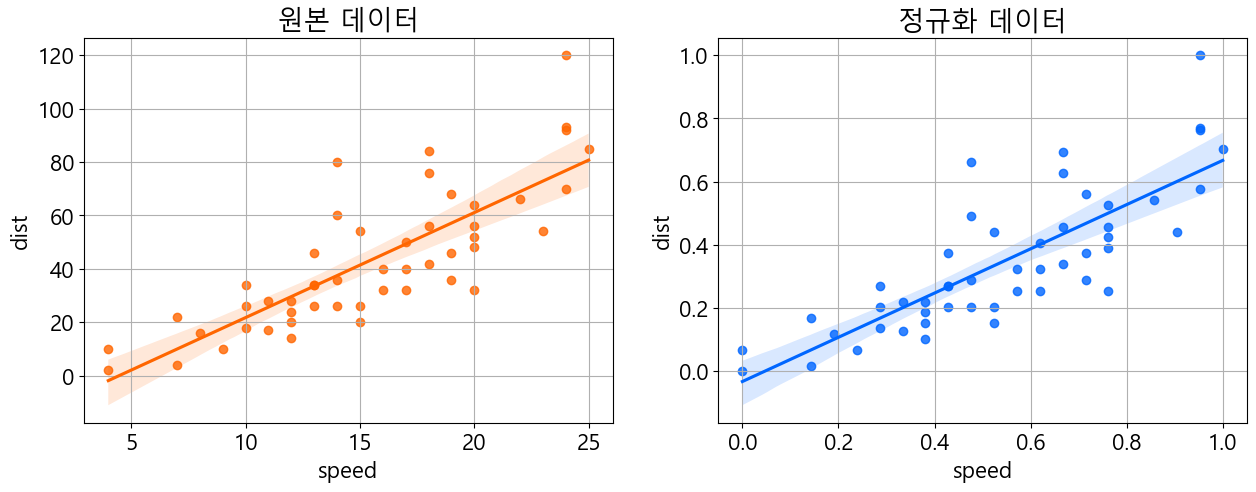

In [47]:
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sb.regplot(data=origin, x='speed', y='dist', color='#ff6600', ax=ax1)
ax1.set_title('원본 데이터')
ax1.grid()

sb.regplot(data=df, x='speed', y='dist', color='#0066ff', ax=ax2)
ax2.set_title('정규화 데이터')
ax2.grid()

plt.show()
plt.close()

In [48]:
np.random.seed(777)

In [49]:
x = df.drop(['dist'], axis=1)
y = df['dist']

In [50]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [51]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(1,)))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics =['mae'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                64        
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 97 (388.00 Byte)
Trainable params: 97 (388.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:
#result = model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test))

result = model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test), callbacks=[
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1),
    ModelCheckpoint(filepath = 'reg_check_point.h5', monitor = 'val_loss', verbose=1, save_best_only = True)
])

# 학습결과
result_df = DataFrame(result.history)
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs', inplace=True)
result_df

Epoch 1/500
1/2 [==============>...............] - ETA: 0s - loss: 0.1521 - mae: 0.3237
Epoch 1: val_loss improved from inf to 0.15963, saving model to reg_check_point.h5
2/2 [==============================] - 1s 147ms/step - loss: 0.1544 - mae: 0.3318 - val_loss: 0.1596 - val_mae: 0.3367 - lr: 0.0010
Epoch 2/500
1/2 [==============>...............] - ETA: 0s - loss: 0.1341 - mae: 0.3051
Epoch 2: val_loss improved from 0.15963 to 0.14565, saving model to reg_check_point.h5
2/2 [==============================] - 0s 60ms/step - loss: 0.1401 - mae: 0.3124 - val_loss: 0.1457 - val_mae: 0.3175 - lr: 0.0010
Epoch 3/500
1/2 [==============>...............] - ETA: 0s - loss: 0.1235 - mae: 0.2929
Epoch 3: val_loss improved from 0.14565 to 0.13260, saving model to reg_check_point.h5
2/2 [==============================] - 0s 44ms/step - loss: 0.1272 - mae: 0.2943 - val_loss: 0.1326 - val_mae: 0.2984 - lr: 0.0010
Epoch 4/500
1/2 [==============>...............] - ETA: 0s - loss: 0.1089 - mae: 0.27

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 53ms/step - loss: 0.1150 - mae: 0.2766 - val_loss: 0.1204 - val_mae: 0.2795 - lr: 0.0010
Epoch 5/500
1/2 [==============>...............] - ETA: 0s - loss: 0.1080 - mae: 0.2654
Epoch 5: val_loss improved from 0.12038 to 0.10922, saving model to reg_check_point.h5
2/2 [==============================] - 0s 71ms/step - loss: 0.1041 - mae: 0.2593 - val_loss: 0.1092 - val_mae: 0.2612 - lr: 0.0010
Epoch 6/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0870 - mae: 0.2308
Epoch 6: val_loss improved from 0.10922 to 0.09896, saving model to reg_check_point.h5
2/2 [==============================] - 0s 77ms/step - loss: 0.0934 - mae: 0.2419 - val_loss: 0.0990 - val_mae: 0.2431 - lr: 0.0010
Epoch 7/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0917 - mae: 0.2407
Epoch 7: val_loss improved from 0.09896 to 0.08965, saving model to reg_check_point.h5
2/2 [==============================] - 0s 61ms/step - loss: 0.0845 - mae: 0.2264 -

,loss,mae,val_loss,val_mae,lr
epochs,,,,,
1,0.154405,0.331839,0.159633,0.336697,0.001000
2,0.140066,0.312415,0.145652,0.317475,0.001000
3,0.127154,0.294317,0.132597,0.298440,0.001000
4,0.114990,0.276554,0.120381,0.279542,0.001000
5,0.104052,0.259258,0.109220,0.261156,0.001000
6,0.093378,0.241926,0.098958,0.243115,0.001000
7,0.084537,0.226449,0.089652,0.225633,0.001000
8,0.075844,0.211594,0.081352,0.208938,0.001000
9,0.068157,0.196939,0.073613,0.192296,0.001000


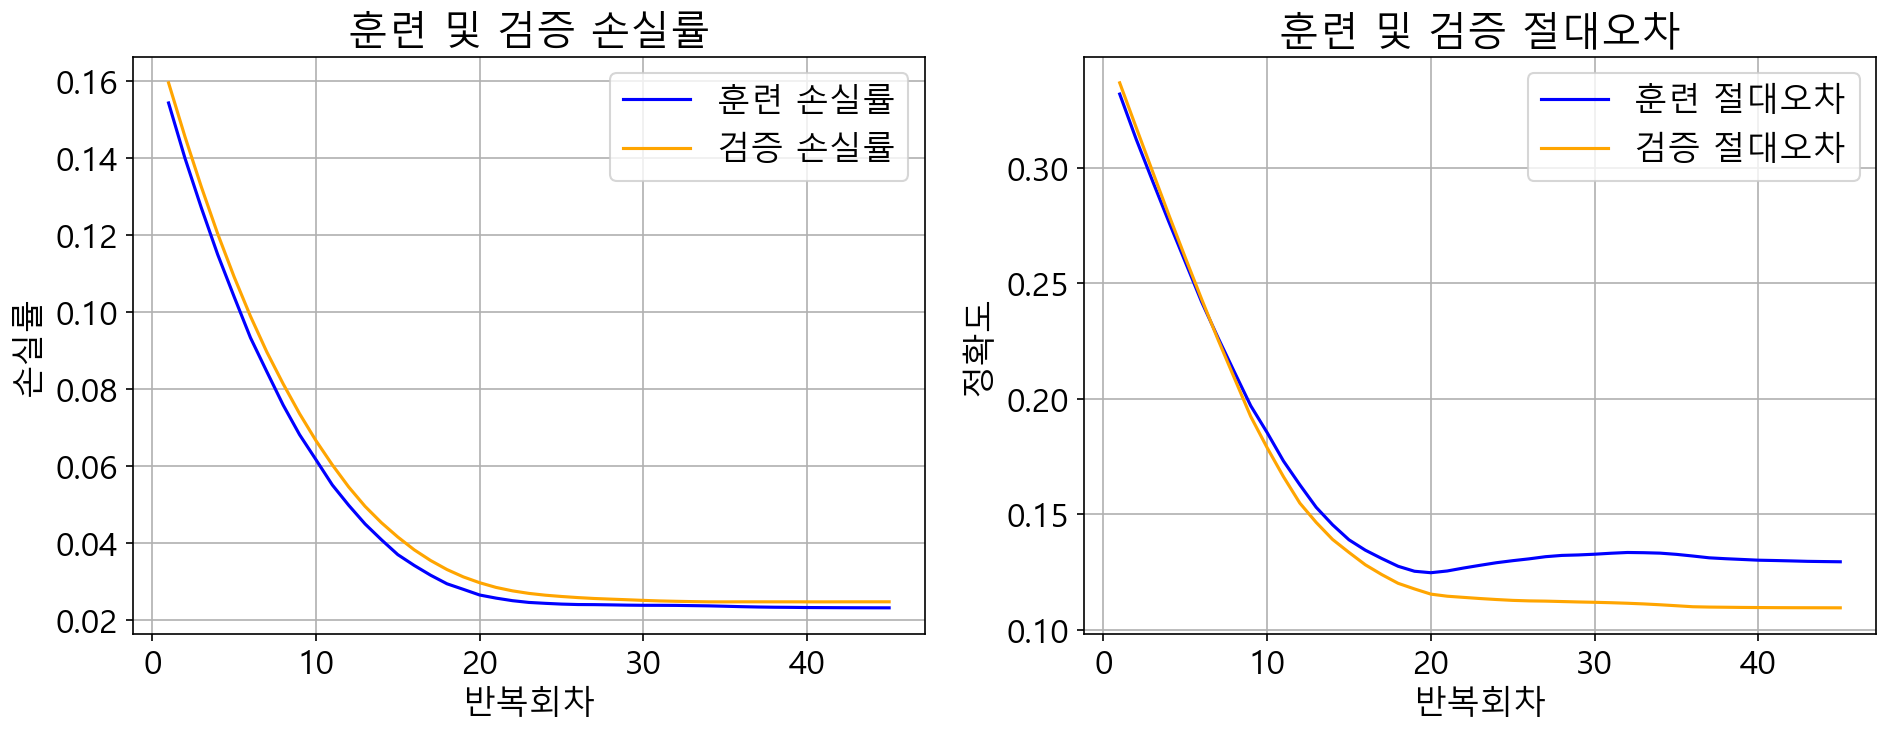

In [53]:
# 그래프 기본 설정
# ----------------------------------------
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

# 그래프를 그리기 위한 객체 생성
# ----------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=150)

# 1) 훈련 및 검증 손실 그리기
# ----------------------------------------
sb.lineplot(x=result_df.index, y='loss', data=result_df, color='blue', label='훈련 손실률', ax=ax1)
sb.lineplot(x=result_df.index, y='val_loss', data=result_df, color='orange', label='검증 손실률', ax=ax1)
ax1.set_title('훈련 및 검증 손실률')
ax1.set_xlabel('반복회차')
ax1.set_ylabel('손실률')
ax1.grid()
ax1.legend()

# 2) 훈련 및 검증 절대오차 그리기
# ----------------------------------------
sb.lineplot(x=result_df.index, y='mae', data=result_df, color = 'blue', label = '훈련 절대오차', ax=ax2)
sb.lineplot(x=result_df.index, y='val_mae', data=result_df, color = 'orange', label = '검증 절대오차', ax=ax2)
ax2.set_title('훈련 및 검증 절대오차')
ax2.set_xlabel('반복회차')
ax2.set_ylabel('정확도')
ax2.grid()
ax2.legend()

plt.show()
plt.close()

> ###### ephocs를 500으로 지정했지만 50회 전에 학습을 멈춘 것을 확일 할 수 있다. 즉, 학습을 조기 종료함으로서 학습 성능을 향상시켰다고 할 수 있다.

In [54]:
evaluate1 = model.evaluate(x_train, y_train)
print(evaluate1[0], evaluate1[1])
evaluate2 = model.evaluate(x_test, y_test)
print(evaluate2[0], evaluate2[1])

2/2 [==============================] - 0s 3ms/step - loss: 0.0231 - mae: 0.1293
0.02313077077269554 0.12931513786315918
1/1 [==============================] - 0s 29ms/step - loss: 0.0247 - mae: 0.1095
0.024713099002838135 0.10947268456220627


In [55]:
results = model.predict(x_test)
print(results)

1/1 [==============================] - 0s 70ms/step
[[0.3034511 ]
 [0.43815595]
 [0.39023024]
 [0.502057  ]
 [0.32177848]
 [0.502057  ]
 [0.37367105]
 [0.35672283]
 [0.40620548]
 [0.33977464]
 [0.3034511 ]
 [0.23014155]
 [0.42218074]
 [0.26679632]
 [0.21181417]]


In [58]:
kdf = DataFrame({
    '검증데이터': x_test['speed'],
    '실제값': y_test,
    '예측값' : results.flatten()
})

kdf['예측오차'] = kdf['실제값']-kdf['예측값']

kdf

,검증데이터,실제값,예측값,예측오차
13,0.380952,0.186441,0.303451,-0.117010
39,0.761905,0.389831,0.438156,-0.048325
30,0.619048,0.406780,0.390230,0.016549
45,0.952381,0.576271,0.502057,0.074214
17,0.428571,0.271186,0.321778,-0.050592
48,0.952381,1.000000,0.502057,0.497943
26,0.571429,0.254237,0.373671,-0.119434
25,0.523810,0.440678,0.356723,0.083955
32,0.666667,0.457627,0.406205,0.051422
19,0.476190,0.203390,0.339775,-0.136385


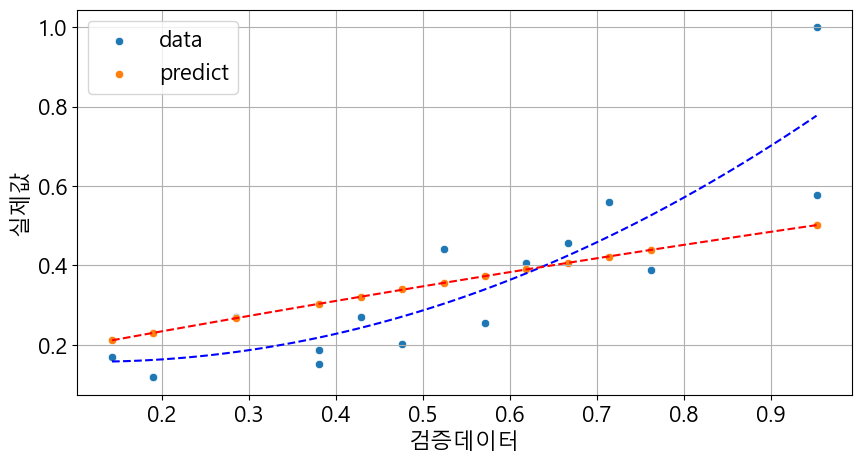

In [59]:
helper.regplot(x_left=kdf['검증데이터'], y_left=kdf['실제값'], y_left_pred=kdf['예측값'])

In [60]:
my_speed = 50
results = model.predict([[my_speed]])
print(my_speed, results)

1/1 [==============================] - 0s 87ms/step
50 [[16.956568]]
